## Install and import libraries



In [ ]:
!nvcc -V
!gcc --version

In [ ]:
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
!pip install openmim
!mim install mmcv-full==1.6.0

In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

In [5]:
import torch, torchvision
import mmseg

## Data

In [6]:
# enter here your path to the "segmentation_project" folder
data_root = '/content/drive/MyDrive/cv-course-data/Segmentation_data/segmentation_project'
img_dir = 'images'
labels_dir = 'labels' 

In [7]:
import os

img_path = os.path.join(data_root, img_dir)
labels_path = os.path.join(data_root, labels_dir)

Let's take a look at the data and its annotation

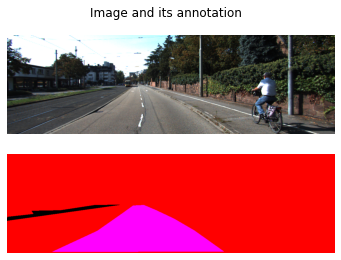

In [9]:
import cv2
import matplotlib.pyplot as plt

img_name = "um_000000.png"
img = cv2.cvtColor(cv2.imread(os.path.join(img_path, img_name)), cv2.COLOR_BGR2RGB)
ann = cv2.cvtColor(cv2.imread(os.path.join(labels_path, img_name)), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(2)
fig.suptitle("Image and its annotation")
for i, im in enumerate([img, ann]):
  axs[i].imshow(im)
  axs[i].set_axis_off()
plt.show();

Define classes and palette for better visualization

In [10]:
n_classes = 2
classes = ['background', 'road']
palette = [(255, 0, 0), (255, 0, 255)] # in rgb color space
palette_to_idx = {color: idx for idx, color in enumerate(palette)}

Convert dataset annotations into semantic segmentation map


In [ ]:
import numpy as np
from PIL import Image
import mmcv

def get_class_id(p):
  try:
    return palette_to_idx[tuple(p)]
  except:
    return 0 # return background class for unknown colors

segmap_dir = 'labels-segmentation-map' 
segmap_path = os.path.join(data_root, segmap_dir)
mmcv.mkdir_or_exist(segmap_path)

for ann_name in mmcv.scandir(labels_path, suffix='.png'):
  ann_path = os.path.join(labels_path, ann_name)
  ann_im = cv2.cvtColor(cv2.imread(ann_path), cv2.COLOR_BGR2RGB)
  # convert rgb mask into class_id mask
  ann_map = np.apply_along_axis(lambda p: get_class_id(p), 2, ann_im)
  # create one channel palettised image
  seg_im = Image.fromarray(ann_map.astype(np.uint8)).convert('P')
  seg_im.putpalette(np.array(palette, dtype=np.uint8))
  seg_path = os.path.join(segmap_path, ann_name)
  seg_im.save(seg_path)

Train/val split

In [13]:
split_dir = 'splits'
split_path = os.path.join(data_root, split_dir)
mmcv.mkdir_or_exist(split_path)
filename_list = [os.path.splitext(filename)[0] for filename in mmcv.scandir(labels_path, suffix='.png')]

train_part = 0.8
train_length = int(len(filename_list) * train_part)

with open(os.path.join(split_path, 'train.txt'), 'w') as f:
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(os.path.join(split_path, 'val.txt'), 'w') as f:
  f.writelines(line + '\n' for line in filename_list[train_length:])

## Dataset

Define custom dataset

In [14]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class RoadDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert os.path.exists(self.img_dir) and self.split is not None

## Config

Download pretrained model

In [ ]:
checkpoints_path = os.path.join(data_root, "checkpoints")
mmcv.mkdir_or_exist(checkpoints_path)
!wget https://download.openmmlab.com/mmsegmentation/v0.5/unet/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes_20211210_145204-6860854e.pth -P $checkpoints_path

Predefined UNET config

In [20]:
from mmcv import Config

cfg = Config.fromfile('configs/unet/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes.py')

Customize config

In [21]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# for one GPU BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.dataset_type = 'RoadDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], 
    std=[58.395, 57.12, 57.375], 
    to_rgb=True
)
cfg.crop_size = (256, 256)

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(400, 1280), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(400, 1280),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize'),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='Pad', size_divisor=16),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = segmap_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = segmap_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = segmap_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

cfg.load_from = checkpoints_path + "/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes_20211210_145204-6860854e.pth"

# set up working dir to save files and logs
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 20
cfg.log_config.interval = 10
cfg.evaluation.interval = 10
cfg.checkpoint_config.interval = 10

# set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

Let's have a look at the final config used for training

In [22]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False),
    decode_head=dict(
        type='FCNHead',
        in_channels=64,
        in_index=4,
        channels=64,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type=

## Train

In [23]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


datasets = [build_dataset(cfg.data.train)]
model = build_segmentor(cfg.model)
model.CLASSES = datasets[0].CLASSES
model.PALETTE = datasets[0].PALETTE
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))

train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta={"PALETTE": datasets[0].PALETTE})

2022-09-08 14:52:13,074 - mmseg - INFO - Loaded 231 images
2022-09-08 14:52:13,524 - mmseg - INFO - Loaded 58 images
2022-09-08 14:52:13,530 - mmseg - INFO - load checkpoint from local path: /content/drive/MyDrive/cv-course-data/Segmentation_data/segmentation_project/checkpoints/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes_20211210_145204-6860854e.pth
2022-09-08 14:52:15,115 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 58/58, 0.9 task/s, elapsed: 64s, ETA:     0s

2022-09-08 14:53:51,953 - mmseg - INFO - per class results:
2022-09-08 14:53:51,955 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 94.53 | 96.15 |
|    road    | 84.03 | 94.47 |
+------------+-------+-------+
2022-09-08 14:53:51,958 - mmseg - INFO - Summary:
2022-09-08 14:53:51,962 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.75 | 89.28 | 95.31 |
+-------+-------+-------+
2022-09-08 14:53:51,963 - mmseg - INFO - Iter(val) [58]	aAcc: 0.9575, mIoU: 0.8928, mAcc: 0.9531, IoU.background: 0.9453, IoU.road: 0.8403, Acc.background: 0.9615, Acc.road: 0.9447
2022-09-08 14:53:56,747 - mmseg - INFO - Saving checkpoint at 20 iterations
2022-09-08 14:53:58,656 - mmseg - INFO - Iter [20/20]	lr: 7.679e-04, eta: 0:00:00, time: 7.032, data_time: 6.365, memory: 4925, decode.loss_ce: 0.1192, decode.acc_seg: 96.4671, aux.loss_ce: 0.0573, aux.acc_seg: 96.4505, loss: 0.1764


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 58/58, 5.0 task/s, elapsed: 12s, ETA:     0s

2022-09-08 14:54:10,291 - mmseg - INFO - per class results:
2022-09-08 14:54:10,294 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  94.3 | 96.47 |
|    road    | 83.12 | 92.59 |
+------------+-------+-------+
2022-09-08 14:54:10,296 - mmseg - INFO - Summary:
2022-09-08 14:54:10,300 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.55 | 88.71 | 94.53 |
+-------+-------+-------+
2022-09-08 14:54:10,305 - mmseg - INFO - Iter(val) [58]	aAcc: 0.9555, mIoU: 0.8871, mAcc: 0.9453, IoU.background: 0.9430, IoU.road: 0.8312, Acc.background: 0.9647, Acc.road: 0.9259


## Inference

#### Load the best trained model checkpoint (300 iteration)
#### **road**: IoU 90.4, Acc 95.85
#### **background**: IoU 96.89, Acc 98.13
#### **mIoU** 93.64, **mAcc** 96.99



In [ ]:
from mmseg.apis import init_segmentor

checkpoint = os.path.join(data_root, "best_model", "iter_300.pth")
best_model = init_segmentor(cfg, checkpoint)
best_model.cfg = cfg

In [25]:
def add_color(p, color):
  new_p = [None] * 3
  for i in range(3):
    new_p[i] = p[i] * 0.5 + color[i] * 0.5
  return np.array(new_p)

def show_predicted_road(imgs, results, road_color=(255, 0, 255)):
  fig, axs = plt.subplots(len(imgs), figsize=(16, 8))
  for i, (img, result) in enumerate(zip(imgs, results)):
    colored_img = np.apply_along_axis(lambda p: add_color(p, road_color), 2, img)
    road_map = (result[0] == 1)
    img[road_map] = colored_img[road_map]
    # plt.axis("off")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_axis_off()

Show results

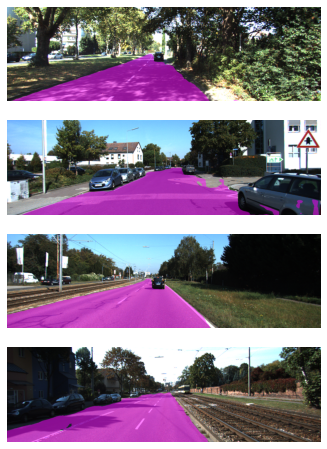

In [26]:
from mmseg.apis import inference_segmentor

test_img_paths = [f'{img_path}/um_000009.png',
                  f'{img_path}/uu_000007.png', 
                  f'{img_path}/um_000027.png',
                  f'{img_path}/umm_000000.png']
imgs = []
results = []
for path in test_img_paths:
  img = mmcv.imread(path)
  imgs.append(img)
  result = inference_segmentor(best_model, img)
  results.append(result)

show_predicted_road(imgs, results)